In [ ]:
!pip install tensorflow

import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import zipfile


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path tempat dataset diunduh di Google Drive
zip_path = "/content/drive/MyDrive/Colab Notebooks/data_gender.zip"

In [ ]:
# Ekstrak dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/gender_classification")

In [ ]:
TRAINING_DIR = "/tmp/gender-classification/training"
VALIDATION_DIR = "/tmp/gender-classification/validation"

In [ ]:
# Fungsi untuk membagi data menjadi training dan validation, serta membuat generator data
def split_data_and_create_generators(TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    for directory in [TRAINING_DIR, VALIDATION_DIR]:
        if os.path.exists(directory):
            shutil.rmtree(directory)

    for directory in [TRAINING_DIR, VALIDATION_DIR]:
        os.makedirs(directory, exist_ok=True)

    categories = ["male", "female"]

    for category in categories:
        os.makedirs(os.path.join(TRAINING_DIR, category), exist_ok=True)
        os.makedirs(os.path.join(VALIDATION_DIR, category), exist_ok=True)

        category_path = os.path.join("/content/gender_classification/data_gender", category)
        files = os.listdir(category_path)

        split_index = int(len(files) * SPLIT_SIZE)
        training_files = files[:split_index]
        validation_files = files[split_index:]

        for file in training_files:
            src = os.path.join(category_path, file)
            dst = os.path.join(TRAINING_DIR, category, file)
            shutil.copyfile(src, dst)

        for file in validation_files:
            src = os.path.join(category_path, file)
            dst = os.path.join(VALIDATION_DIR, category, file)
            shutil.copyfile(src, dst)

        print(f"Kategori {category}:")
        print(f"  - Jumlah data training: {len(training_files)}")
        print(f"  - Jumlah data validation: {len(validation_files)}")

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    batch_size = 32
    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, validation_generator

train_generator, validation_generator = split_data_and_create_generators(TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE=0.8)


Kategori male:
  - Jumlah data training: 8
  - Jumlah data validation: 2
Kategori female:
  - Jumlah data training: 8
  - Jumlah data validation: 2
Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [ ]:
# Definisi model ANN
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,291,713 (24.00 MB)

 Trainable params: 6,291,713 (24.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Melatih model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3750 - loss: 0.9270 - val_accuracy: 0.5000 - val_loss: 9.6147
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.4375 - loss: 10.7795 - val_accuracy: 0.5000 - val_loss: 27.8996
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5000 - loss: 21.7326 - val_accuracy: 0.5000 - val_loss: 23.1637
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5625 - loss: 18.2699 - val_accuracy: 0.5000 - val_loss: 2.4767
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6250 - loss: 6.6397 - val_accuracy: 0.5000 - val_loss: 22.1346
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.6875 - loss: 8.0847 - val_accuracy: 0.5000 - val_loss: 34.1664
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5625 - loss: 16.1207 - val_accuracy: 0.5000 - val_loss: 30.7846
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5000 - loss: 20.6397 - val_accuracy: 0.5000 - va

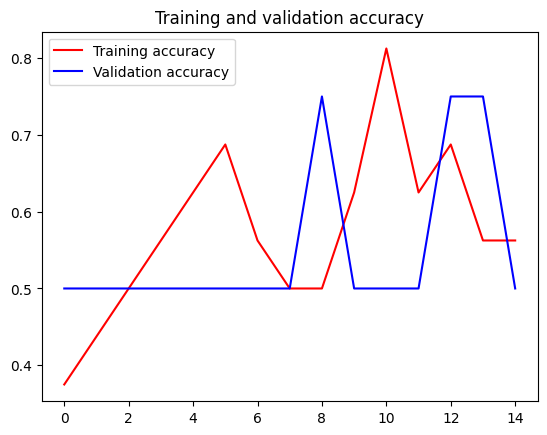

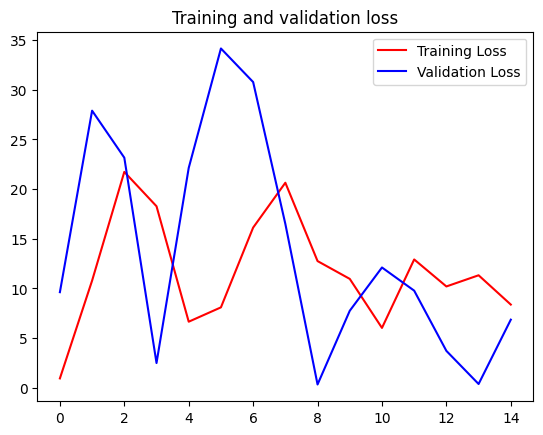

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import files

Saving 𓆩♡𓆪.jpg to 𓆩♡𓆪.jpg
User uploaded file "𓆩♡𓆪.jpg"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


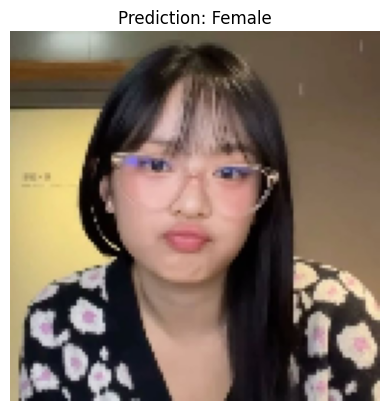

In [ ]:
# Fungsi untuk memprediksi gambar yang diupload dan menampilkan hasil
def predict_and_show_image(image_path, model):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    if prediction[0] >= 0.5:
        predicted_class = "Male"
    else:
        predicted_class = "Female"

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Unggah dan prediksi gambar
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    predict_and_show_image(fn, model)